In [1]:
%load_ext autoreload
%autoreload 2

# Scan and detect

## Line scan

Scanning imaging modes such as STEM works by scanning an electron probe across a sample and recording the scattering signal. As in earlier tutorials, we import our graphene potential and create a probe.

In [2]:
from abtem.waves import ProbeWaves
from abtem.io import read
import numpy as np

probe = ProbeWaves(energy=60e3, semiangle_cutoff=.03, focal_spread=30, defocus=50)
potential = read('graphene_potential.hdf5')

There . The `LineScan` scan the probe along a straight line 
the `CustomScan` object can scan over any arbitrary region given by an array of positions.

Below we create a linescan object, that scan between two atoms. The scan objects can be given as an argument in the plotting method of 2d arrays or the `plot_atoms` function to visualise the scan region.

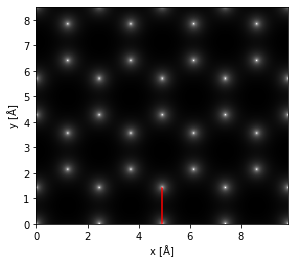

In [3]:
from abtem.scan import LineScan

linescan = LineScan(start=[2 * np.sqrt(3) * 1.42, 0], end=[2 * np.sqrt(3) * 1.42, 1.42], gpts=200)

potential.projection().plot(scans=linescan);

The scan objects allows the creation of a generator of exit probes. The `max_batch` controls the number probes propagated simultaneously, larger batches allows for better parallelism and hence speed. The actual speedup will depend on the number of threads, hence GPU's are better at taking advantage of large batches. The batch size should be balanced by the memory requirement.

If `max_batch` is given as an integer it is the actual maximum number of waves per batch. If given as a string terminated by a 'b', e.g. '100Mb' or '4Gb', the maximum batch is calculated to fill the indicated amount of memory. Lastly, if given as a string terminated by a percent sign, e.g. '50%', maximum batch is allowed to fill '50%' of the available memory.

The following code generates 50 probes at different positions and propagates them through the potential.

In [4]:
generator = probe.generate_probes(linescan, potential, max_batch=50)

first_index, last_index, exit_probes = next(generator)

The memory usage in bytes of the batch can be obtained from the memory usage property, hence in this case the batches take up 84 Mb of memory.

In [5]:
exit_probes.shape, exit_probes.memory_usage * 1e-6

((50, 493, 427), 84.204528)

## Detect

In real experiments the exit probes are not directly detected, in abTEM, the way the signal is detected is controlled by the detector objects. There are several different types detectors, for now we focus on the basic `AnnularDetector`, this can represent the detector used in bright field, medium and high angle annular dark field microscopy, depending on the choice of integration region. The integration region is given by an inner and outer radius in radians; below we create three different types of detectors, and plot their respective integration regions.

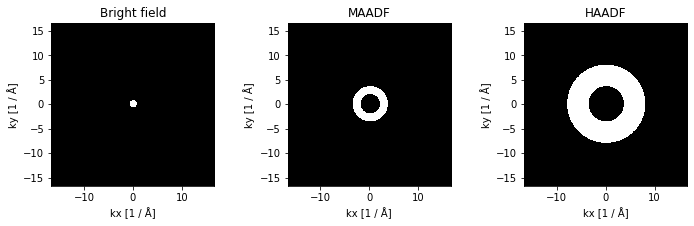

In [6]:
from abtem.detect import AnnularDetector
import matplotlib.pyplot as plt

bright = AnnularDetector(inner=.0, outer=.02, extent=10, sampling=.03, energy=200e3)
maadf = AnnularDetector(inner=.05, outer=.09, extent=10, sampling=.03, energy=200e3)
haadf = AnnularDetector(inner=.09, outer=.2, extent=10, sampling=.03, energy=200e3)

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12,3))

bright.get_integration_region().plot(ax=ax1, title='Bright field')
maadf.get_integration_region().plot(ax=ax2, title='MAADF')
haadf.get_integration_region().plot(ax=ax3, title='HAADF');

The probes can be detected using the `.detect` method, this condenses each probe down to a single integrated intensity.

In [7]:
detector = AnnularDetector(inner=.09, outer=.2)
detector.detect(exit_probes)

array([0.00039059, 0.00039054, 0.00039039, 0.00039013, 0.00038978,
       0.00038933, 0.00038878, 0.00038813, 0.00038738, 0.00038653,
       0.00038559, 0.00038455, 0.00038341, 0.00038218, 0.00038085,
       0.00037943, 0.00037791, 0.00037631, 0.00037462, 0.00037284,
       0.00037097, 0.00036902, 0.00036699, 0.00036488, 0.00036268,
       0.00036041, 0.00035807, 0.00035565, 0.00035316, 0.00035061,
       0.00034798, 0.0003453 , 0.00034255, 0.00033975, 0.00033689,
       0.00033398, 0.00033102, 0.00032801, 0.00032496, 0.00032187,
       0.00031874, 0.00031557, 0.00031238, 0.00030915, 0.0003059 ,
       0.00030263, 0.00029934, 0.00029603, 0.00029271, 0.00028938],
      dtype=float32)

Usually, we would like to condense the exit probes during the scan in order to save memory. Hence, the typical syntax for simulating STEM experiment requires giving the detector(s) as an argument of the scan object.

In [8]:
measurements = probe.scan(scan, potential, detectors, max_batch=50)

NameError: name 'detectors' is not defined

The output is a dictionary of measurements with one entry per detector.

In [11]:
measurements

{<abtem.detect.AnnularDetector at 0x16feffd2548>: <abtem.bases.ArrayWithGrid1D at 0x16ff0024d88>}

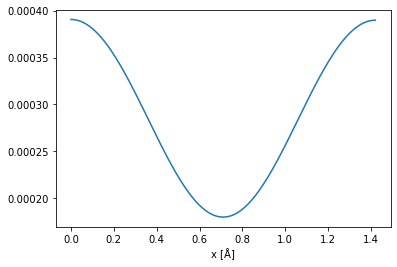

In [12]:
measurements[detector].plot()

## Grid scan

The `GridScan` object is used essentially the same as the `LineScan` object. In the following we scan over a tilable section of of the potential. By specifying an output file ofr the detector, we dump the measurements directly to a file as they are made.

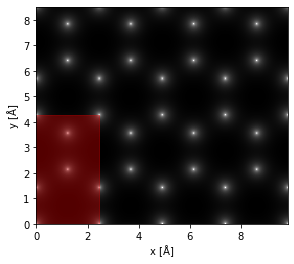

In [13]:
detector = AnnularDetector(inner=.086, outer=.19, output='gridscan.hdf5')
gridscan = GridScan(probe, potential, detectors=detector, start=[0,0], end=[np.sqrt(3) * 1.42, 3 * 1.42], sampling=.1)

potential.projection().plot(scans=gridscan);

The number of positions in a densely sampled grid can obviously be large, hence it may be useful to show the progress as below.

In [17]:
gridscan.go(max_batch=100, show_progress=True);

We read back in the measurements from disk and tile it.

(<matplotlib.axes._subplots.AxesSubplot at 0x16f800df808>,
 <matplotlib.image.AxesImage at 0x16f800b6e48>)

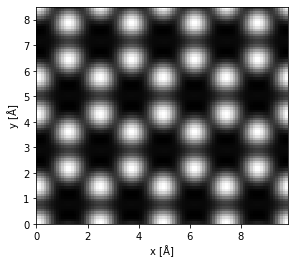

In [15]:
read('gridscan.hdf5').tile((4, 2)).plot()

It is not possible to save directly to an image file during the scan, however, it is straightforward to export the measurement as an image. 

In [16]:
read('gridscan.hdf5').tile((4, 2)).save_as_image('gridscan.tif')

## Custom detector

Current detector hardware is far from perfect with detectors exhibiting significant asymmetries or non-uniformities across their active region
The `CustomDetector` allows the user to set the detector efficiency using an array, e.g. representing a measured detector efficiency.